# Example of genetic algorithm to find the coefficientes a, b and c of quadratic function f(x) = ax² + bx + c that results the flattest parabola. objective is to create the flattest U-shape

- [Genetic Algorithm: Complete Guide With Python Implementation](https://www.datacamp.com/tutorial/genetic-algorithm-python)

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

In [10]:
f = lambda x, a, b, c: a * x**2 + b * x + c


# Create the initial population
def create_initial_population(size, lower_bound, upper_bound):
    population = []
    for _ in range(size):
        individual = (random.uniform(lower_bound, upper_bound),
                      random.uniform(lower_bound, upper_bound),
                      random.uniform(lower_bound, upper_bound))
        population.append(individual)
    return population


def get_genotype(individual: np.ndarray) -> str:
    return ''.join([str(bit) for bit in individual])


def get_phenotype(individual: np.ndarray) -> int:
    return int(''.join([str(bit) for bit in individual]), 2)


# Define the fitness function (objective is to create the flattest U-shape)
def fitness_function(params):
    a, b, c = params
    if a <= 0:
        return -float('inf')  # Penalize downward facing u-shapes heavily
    vertex_x = -b / (2 * a) #x value at vertex
    vertex_y = a * (vertex_x ** 2) + b * vertex_x + c #y value at vertex
    y_left = a * (-1) ** 2 + b * (-1) + c #y-coordinate at x = -1
    y_right = a * (1) ** 2 + b * (1) + c #y-coordinate at x = 1
    curviness = abs(y_left - vertex_y) + abs(y_right - vertex_y)
    return -curviness  # Negate to minimize curviness


# Selection function using tournament selection
def selection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected


# Crossover function
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = tuple(alpha * p1 + (1 - alpha) * p2 for p1, p2 in zip(parent1, parent2))
    child2 = tuple(alpha * p2 + (1 - alpha) * p1 for p1, p2 in zip(parent1, parent2))
    return child1, child2


# Mutation function
def mutation(individual, mutation_rate, lower_bound, upper_bound):
    individual = list(individual)
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            mutation_amount = random.uniform(-1, 1)
            individual[i] += mutation_amount
            # Ensure the individual stays within bounds
            individual[i] = max(min(individual[i], upper_bound), lower_bound)
    return tuple(individual)


# Main genetic algorithm function
def genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate):
    population = create_initial_population(population_size, lower_bound, upper_bound)
    
    # Prepare for plotting
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))  # 1 row, 3 columns for subplots
    best_performers = []
    all_populations = []

    # Prepare for table
    table = PrettyTable()
    table.field_names = ["Generation", "a", "b", "c", "Fitness"]

    for generation in range(generations):
        fitnesses = [fitness_function(ind) for ind in population]

        # Store the best performer of the current generation
        best_individual = max(population, key=fitness_function)
        best_fitness = fitness_function(best_individual)
        best_performers.append((best_individual, best_fitness))
        all_populations.append(population[:])
        table.add_row([generation + 1, best_individual[0], best_individual[1], best_individual[2], best_fitness])

        population = selection(population, fitnesses)

        next_population = []
        for i in range(0, len(population), 2):
            parent1 = population[i]
            parent2 = population[i + 1]

            child1, child2 = crossover(parent1, parent2)

            next_population.append(mutation(child1, mutation_rate, lower_bound, upper_bound))
            next_population.append(mutation(child2, mutation_rate, lower_bound, upper_bound))

        # Replace the old population with the new one, preserving the best individual
        next_population[0] = best_individual
        population = next_population

    # Print the table
    print(table)

    # Plot the population of one generation (last generation)
    final_population = all_populations[-1]
    final_fitnesses = [fitness_function(ind) for ind in final_population]

    axs[0].scatter(range(len(final_population)), [ind[0] for ind in final_population], color='blue', label='a')
    axs[0].scatter([final_population.index(best_individual)], [best_individual[0]], color='cyan', s=100, label='Best Individual a')
    axs[0].set_ylabel('a', color='blue')
    axs[0].legend(loc='upper left')
    
    axs[1].scatter(range(len(final_population)), [ind[1] for ind in final_population], color='green', label='b')
    axs[1].scatter([final_population.index(best_individual)], [best_individual[1]], color='magenta', s=100, label='Best Individual b')
    axs[1].set_ylabel('b', color='green')
    axs[1].legend(loc='upper left')
    
    axs[2].scatter(range(len(final_population)), [ind[2] for ind in final_population], color='red', label='c')
    axs[2].scatter([final_population.index(best_individual)], [best_individual[2]], color='yellow', s=100, label='Best Individual c')
    axs[2].set_ylabel('c', color='red')
    axs[2].set_xlabel('Individual Index')
    axs[2].legend(loc='upper left')
    
    axs[0].set_title(f'Final Generation ({generations}) Population Solutions')

    # Plot the values of a, b, and c over generations
    generations_list = range(1, len(best_performers) + 1)
    a_values = [ind[0][0] for ind in best_performers]
    b_values = [ind[0][1] for ind in best_performers]
    c_values = [ind[0][2] for ind in best_performers]
    fig, ax = plt.subplots()
    ax.plot(generations_list, a_values, label='a', color='blue')
    ax.plot(generations_list, b_values, label='b', color='green')
    ax.plot(generations_list, c_values, label='c', color='red')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Parameter Values')
    ax.set_title('Parameter Values Over Generations')
    ax.legend()

    # Plot the fitness values over generations
    best_fitness_values = [fit[1] for fit in best_performers]
    min_fitness_values = [min([fitness_function(ind) for ind in population]) for population in all_populations]
    max_fitness_values = [max([fitness_function(ind) for ind in population]) for population in all_populations]
    fig, ax = plt.subplots()
    ax.plot(generations_list, best_fitness_values, label='Best Fitness', color='black')
    ax.fill_between(generations_list, min_fitness_values, max_fitness_values, color='gray', alpha=0.5, label='Fitness Range')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.set_title('Fitness Over Generations')
    ax.legend()

    # Plot the quadratic function for each generation
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, generations))
    for i, (best_ind, best_fit) in enumerate(best_performers):
        color = colors[i]
        a, b, c = best_ind
        x_range = np.linspace(lower_bound, upper_bound, 400)
        y_values = a * (x_range ** 2) + b * x_range + c
        ax.plot(x_range, y_values, color=color)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Quadratic Function')

    # Create a subplot for the colorbar
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
    norm = plt.cm.colors.Normalize(vmin=0, vmax=generations)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, cax=cax, orientation='vertical', label='Generation')

    plt.show()

    return max(population, key=fitness_function)

+------------+---------------------+-----------------------+--------------------+----------------------+
| Generation |          a          |           b           |         c          |       Fitness        |
+------------+---------------------+-----------------------+--------------------+----------------------+
|     1      |  0.5761223937402846 |  -0.12960057874066422 | 2.4174499505989786 |  -1.166821820236466  |
|     2      |  0.5761223937402846 |  -0.12960057874066422 | 2.4174499505989786 |  -1.166821820236466  |
|     3      |  0.5761223937402846 |  -0.12960057874066422 | 2.4174499505989786 |  -1.166821820236466  |
|     4      |  0.5761223937402846 |  -0.12960057874066422 | 2.4174499505989786 |  -1.166821820236466  |
|     5      |  0.5761223937402846 |  -0.12960057874066422 | 2.4174499505989786 |  -1.166821820236466  |
|     6      |  0.5761223937402846 |  -0.12960057874066422 | 2.4174499505989786 |  -1.166821820236466  |
|     7      | 0.06037603950594983 | -0.014678237150941

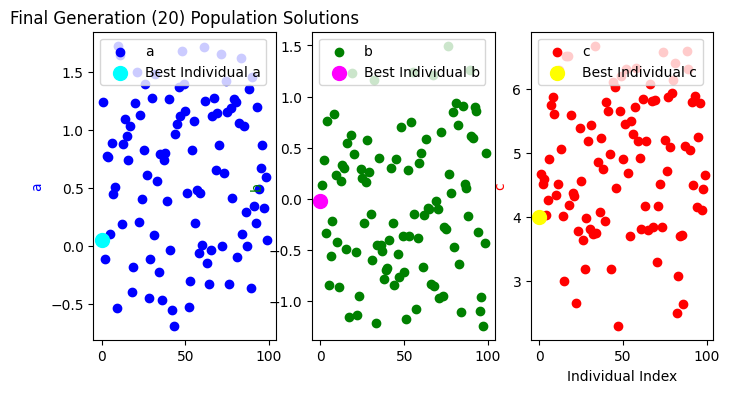

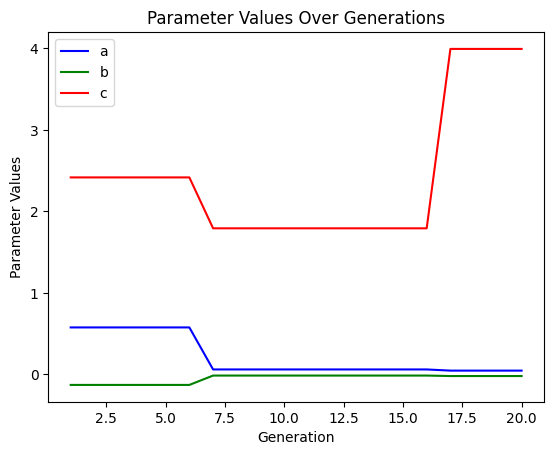

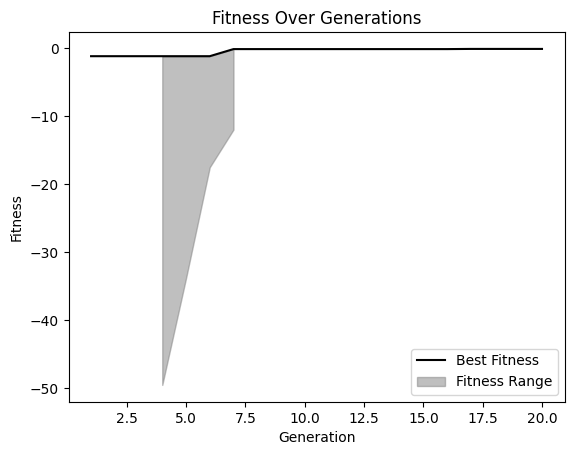

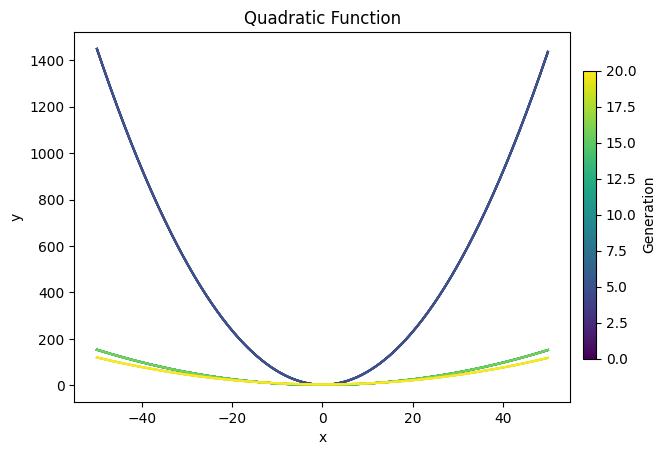

Best solution found: a = 0.04600985159706861, b = -0.020674362045867145, c = 3.9946077670997346


In [11]:
# Parameters for the genetic algorithm
population_size = 100
lower_bound = -50
upper_bound = 50
generations = 20
mutation_rate = 1

# Run the genetic algorithm
best_solution = genetic_algorithm(population_size, lower_bound, upper_bound, generations, mutation_rate)
print(f"Best solution found: a = {best_solution[0]}, b = {best_solution[1]}, c = {best_solution[2]}")